# NSERC Project: E. coli Essential Gene Dataset Assembly
Author: __Nashira H. Ridgeway__
<br>
Created: _Tuesday, February 11th, 2025_
<br>
Last Modified: _July 10, 2025_

This notebook depicts the import and cleaning of various datasets of essential genes for E. coli, as gathered from various publications. A combined total of 8 datasets included represent different methodologies for determining gene essentiality, and in one case, a different strain of E. coli. Specifically, all datasets except the Tn-seq EHEC dataset represent K-12 E. coli populations. <br><br> The methods applied can be split into two basic approaches:
<br>
__(1)__ - __The targeted deletion of individual genes__, as represented by the Keio Collection [1,2].
<br>
__(2)__ - __Random mutagenesis (transposon-insertion sequencing methods)__, as represented by the four TraDIS datasets [3, 4], and the two tn-seq datasets [5]. 
<br>
__(3)__ - __Random mutagenesis (CRISPRi)__, applies 92,000 guide RNAs to randomly mutate and determine gene essentiality [6].
<br>

<br> In addition to formatting, a visualization of the deviations and similarities between each dataset will be compiled through an UpSet Plot. To properly translate gene IDs, EcoCyc will be employed [7]. 
***


[1] _Baba T, Ara T, Hasegawa M, Takai Y, Okumura Y, Baba M, Datsenko KA, Tomita M, Wanner BL, Mori H. Construction of Escherichia coli K-12 in-frame, single-gene knockout mutants: the Keio collection. Mol Syst Biol. 2006;2:2006.0008. doi: 10.1038/msb4100050. Epub 2006 Feb 21. PMID: 16738554; PMCID: PMC1681482._<br>
[2] _Yamamoto N, Nakahigashi K, Nakamichi T, Yoshino M, Takai Y, Touda Y, Furubayashi A, Kinjyo S, Dose H, Hasegawa M, Datsenko KA, Nakayashiki T, Tomita M, Wanner BL, Mori H. Update on the Keio collection of Escherichia coli single-gene deletion mutants. Mol Syst Biol. 2009;5:335. doi: 10.1038/msb.2009.92. Epub 2009 Dec 22._<br>
[3] _Goodall ECA, Robinson A, Johnston IG, Jabbari S, Turner KA, Cunningham AF, Lund PA, Cole JA, Henderson IR. The Essential Genome of Escherichia coli K-12. mBio. 2018 Feb 20;9(1):e02096-17. doi: 10.1128/mBio.02096-17. PMID: 29463657; PMCID: PMC5821084._<br>
[4] _A. Ghomi F, Jung JJ, Langridge GC, Cain AK, Boinett CJ, Abd El Ghany M, Pickard DJ, Kingsley RA, Thomson NR, Parkhill J, Gardner PP, Barquist L. 2024. High-throughput transposon mutagenesis in the family Enterobacteriaceae reveals core essential genes and rapid turnover of essentiality. mBio 15:e01798-24._<br>
[5] _Warr AR, Hubbard TP, Munera D, Blondel CJ, Abel Zur Wiesch P, Abel S, Wang X, Davis BM, Waldor MK. Transposon-insertion sequencing screens unveil requirements for EHEC growth and intestinal colonization. PLoS Pathog. 2019 Aug 12;15(8):e1007652. doi: 10.1371/journal.ppat.1007652. PMID: 31404118; PMCID: PMC6705877._<br>
[6] _Rousset, François, et al. "The impact of genetic diversity on gene essentiality within the Escherichia coli species." Nature microbiology 6.3 (2021): 301-312._<br>
[7] _Moore, Lisa R, Ron Caspi, Dana Boyd, Mehmet Berkmen, Amanda Mackie, Suzanne Paley, and Peter D Karp. “Revisiting the Y-Ome of Escherichia Coli.” Nucleic Acids Research 52, no. 20 (November 11, 2024): 12201–7. https://doi.org/10.1093/nar/gkae857._<br>


In [1]:
import pandas as pd
import numpy as np
import itertools
from upsetplot import plot
from matplotlib import pyplot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # suppress annoying FutureWarnings that appear for UpSetPlot

### Format Data for Proper Comparison
<br>
Each of our datasets are obtained from differing publications and as a result contain a variety of symbols for labelling and formatting. In this first step, we need to obtain consistency so we can effectively compare the data represented by each approach.

In [2]:
#### IMPORT ####
# Import datasets from our essential genes folder
tradis_k12 = pd.read_csv('./E_Coli_Essential_Genes_Datasets/goodall_tradis_list.csv')
tn_ehec = pd.read_csv('./E_Coli_Essential_Genes_Datasets/Warr_tnseq_ehec.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
tn_k12 = pd.read_csv('./E_Coli_Essential_Genes_Datasets/Warr_tnseq_k-12.csv').dropna(axis=1, how='all')
crispri = pd.read_csv('./E_coli_Essential_Genes_Datasets/rousset_et_al_crispri_e_coli_essential_genes.csv')

# multi-tradis dset (isolate just e. coli):
t_init = pd.read_csv('./E_coli_Essential_Genes_Datasets/ghomi_et_al_tradis_sets.csv')
tl = list(t_init.columns[t_init.columns.str.contains('Escherichia')])
tl.append('Keio gene name')
tradis = t_init[tl]
tradis = tradis.rename(columns={'Keio gene name':'gene_name', 'Locus: Escherichia coli BW25113 (Keio)':'b_id'})


In [3]:
#### FORMAT ####
# Need all datasets to be consistent, use the b identifier 
# Make a list of gene names -> b IDs using the tradis dataset
decoder = tradis[['gene_name', 'b_id']]
decoder = decoder.dropna().reset_index(drop=True)

In [4]:
# Split the tradis set up into different E. coli strains
tradis_1 = tradis[['gene_name', 'b_id','TraDIS Essentiality: Escherichia coli ST131 EC958']].rename(columns={'TraDIS Essentiality: Escherichia coli ST131 EC958':'EC958_Gene_Essentiality'})
tradis_2 = tradis[['gene_name', 'b_id','TraDIS Essentiality: Escherichia coli UPEC ST131 NCTC13441']].rename(columns={'TraDIS Essentiality: Escherichia coli UPEC ST131 NCTC13441':'NCTC13441_Gene_Essentiality'})
tradis_3 = tradis[['gene_name', 'b_id','TraDIS Essentiality: Escherichia coli BW25113']].rename(columns={'TraDIS Essentiality: Escherichia coli BW25113':'BW25113_Gene_Essentiality'})
keio = tradis[['gene_name', 'b_id', 'EcoGene Essentiality: Escherichia coli BW25113']].rename(columns={'EcoGene Essentiality: Escherichia coli BW25113':'Keio_Gene_Essentiality'})

In [5]:
# Need to apply the decoder to generate b IDs for the datasets that only list Gene identifiers (crispri + tradis_k12)
temp_tk12 = pd.merge(decoder.rename(columns={'gene_name':'Gene'}), tradis_k12, on='Gene', how='outer', indicator=True)
tradis_k12_no_b_id = temp_tk12[temp_tk12['_merge'] != 'both']
tradis_k12_final = temp_tk12.drop(tradis_k12_no_b_id.index).drop(columns=['_merge']).reset_index(drop=True)

In [6]:
temp_cr = pd.merge(crispri.rename(columns={'gene':'gene_name'}), decoder, on='gene_name', how='outer', indicator=True)
crispri_no_b_id = temp_cr[temp_cr['_merge'] != 'both']
crispri_final = temp_cr.drop(crispri_no_b_id.index).drop(columns=['_merge']).reset_index(drop=True)

In [7]:
#### FORMAT, PART 2 ####
# Need to create consistent formatting for proper comparison
# Need lists of genes (by b-ID), with essential or nonessential tagged (0 if nonessential, 1 if essential)

# Start with tradis_k12 
tradis_k12_final.loc[tradis_k12_final['Essential'] == False, 'Gene Essentiality'] = 0
tradis_k12_final.loc[tradis_k12_final['Essential'] == True, 'Gene Essentiality'] = 1
tradis_k12_final = pd.DataFrame(tradis_k12_final[['b_id', 'Gene Essentiality']])
tradis_k12_final = tradis_k12_final.rename(columns={'b_id':'b ID', 'Gene Essentiality':'TraDIS K12 Gene Essentiality'})

In [8]:
# tnSeq K-12
tn_k12.loc[tn_k12['EL-ARTIST Call'] == 'Neutral', 'Gene Essentiality'] = 0
tn_k12.loc[tn_k12['EL-ARTIST Call'] == 'Underrepresented', 'Gene Essentiality'] = 1
tn_k12.loc[tn_k12['EL-ARTIST Call'] == 'Regional', 'Gene Essentiality'] = 0
tn_k12_f = pd.DataFrame(tn_k12[['Locus Tag', 'Gene Essentiality']])
tn_k12_f = tn_k12_f.rename(columns={'Locus Tag':'b ID', 'Gene Essentiality':'tnSeq K12 Gene Essentiality'})

In [9]:
# tnSeq EHEC -- need to isolate those with K12 homologs only, then apply the same logic as applied to K-12 above
tn_ehec.loc[tn_ehec['EL-ARTIST Call'] == 'Neutral', 'tnSeq EHEC Gene Essentiality'] = 0
tn_ehec.loc[tn_ehec['EL-ARTIST Call'] == 'Underrepresented', 'tnSeq EHEC Gene Essentiality'] = 1
tn_ehec.loc[tn_ehec['EL-ARTIST Call'] == 'Regional', 'tnSeq EHEC Gene Essentiality'] = 0
tn_ehec_f = pd.DataFrame(tn_ehec[['K12 Homolog ', 'tnSeq EHEC Gene Essentiality']])
tn_ehec_f = tn_ehec_f[tn_ehec_f['K12 Homolog '] != '---'].reset_index(drop=True)
tn_ehec_f = tn_ehec_f.rename(columns={'K12 Homolog ':'b ID'})

In [10]:
len(tn_ehec_f[tn_ehec_f['tnSeq EHEC Gene Essentiality'] == 1])

537

In [11]:
len(tn_k12_f[tn_k12_f['tnSeq K12 Gene Essentiality'] == 1])

786

In [12]:
# keio 
keio_f = keio.drop(columns=['gene_name']).rename(columns={'b_id':'b ID', 'Keio_Gene_Essentiality':'Keio Gene Essentiality'})
keio_f = keio_f[keio_f['b ID'].isna() != True].reset_index(drop=True)

In [13]:
# crispri
crispri_f = crispri_final[['b_id', 'essential']].rename(columns={'b_id':'b ID', 'essential':'CRISPRi K12 Gene Essentiality'})


In [14]:
# tradis 1
tr1_f = tradis_1[['b_id', 'EC958_Gene_Essentiality']].rename(columns={'b_id':'b ID'})
tr1_f.loc[tr1_f['EC958_Gene_Essentiality'] <= -2, 'TraDIS EC958 Gene Essentiality'] = 1
tr1_f.loc[tr1_f['EC958_Gene_Essentiality'] > -2, 'TraDIS EC958 Gene Essentiality'] = 0
tr1_f = tr1_f.drop(columns = ['EC958_Gene_Essentiality'])
tr1_f = tr1_f.dropna()

In [15]:
#tradis_2
tr2_f = tradis_2[['b_id', 'NCTC13441_Gene_Essentiality']].rename(columns={'b_id':'b ID'})
tr2_f.loc[tr2_f['NCTC13441_Gene_Essentiality'] <= -2, 'TraDIS NCTC13441 Gene Essentiality'] = 1
tr2_f.loc[tr2_f['NCTC13441_Gene_Essentiality'] > -2, 'TraDIS NCTC13441 Gene Essentiality'] = 0
tr2_f = tr2_f.drop(columns = ['NCTC13441_Gene_Essentiality'])
tr2_f = tr2_f.dropna()

In [16]:
#tradis_3
tr3_f = tradis_3[['b_id', 'BW25113_Gene_Essentiality']].rename(columns={'b_id':'b ID'})
tr3_f.loc[tr3_f['BW25113_Gene_Essentiality'] <= -2, 'TraDIS BW25113 Gene Essentiality'] = 1
tr3_f.loc[tr3_f['BW25113_Gene_Essentiality'] > -2, 'TraDIS BW25113 Gene Essentiality'] = 0
tr3_f = tr3_f.drop(columns = ['BW25113_Gene_Essentiality'])
tr3_f = tr3_f.dropna()

In [17]:
to_compare = [crispri_f, tradis_k12_final, tn_ehec_f, tn_k12_f, keio_f, tr1_f, tr2_f, tr3_f]

### Concern
There are quite a few duplicated gene names within each dataset. In those with a b identifier, the IDs differ for those that share a gene name... 

The main issue is that the TraDIS dataset doesn't list any alternative ID but the gene names, and those gene names show up multiple times within the same list with differing recorded experimental values. To further complicate things, the Keio Collection updated dataset of essential genes didn't list anything but gene names as well, and those are repeated within the list as well. This is in part due to the fact that the 299 essential genes weren't published with the update (just the nonessential list), so I'm pulling the 299 from a publication which took it from an archive of the EcoGene database... **I need to look into a better way of accessing this data with additional annotations-- start with trying to access the EcoGene archive myself.**

I think the best plan forward is to stick with the gene names and drop duplicate names (if a duplicate lists the gene as essential take it). 

If I am able to isolate the b IDs for that Keio update, it may be a better idea to use the 3 datasets with b IDs in the case that genes get missed out on due to duplicate gene names. 

***

#### March 3rd Update
Addressed the concern, found a publication with a list decoding the Keio gene IDs to b IDs, applied within decoder. May lose some values, but unfortunately that is unavoidable due to the varied notations within the varied publications, to be expected as they span several decades. Updated the code above to reflect this, so now all dataframes contain the same b identifiers (b ID), as well as a 0 or 1 for gene essentiality. Ready to carry on with the isolation of solely the essential genes for subsequent comparative analysis. 

***

### Create an Array to Compare the Datasets for Subsequent Graphing
Create a cohesive array eventual visualization, as well as a list of all overlapping genes. Export these to .csv for further analysis.

In [18]:
crispri_f.loc[crispri_f['CRISPRi K12 Gene Essentiality'] == False, 'CRISPRi K12 Gene Essentiality'] = 0
crispri_f.loc[crispri_f['CRISPRi K12 Gene Essentiality'] == True, 'CRISPRi K12 Gene Essentiality'] = 1

categories = ['CRISPRi K-12', 'TraDIS K-12', 'tnSeq EHEC', 'tnSeq K-12', 'Keio Collection', 'TraDIS EC958', 'TraDIS NCTC 13441', 'TraDIS K-12 v2']

In [19]:
# Plot the UpSet plot of just essential genes
essentiality_cols = []
for df in to_compare:
    essentiality_cols.append(df.columns[1])

# Build the list of essential gene sets
essential_sets = []
for df, col in zip(to_compare, essentiality_cols):
    essentials = set(df[df[col] == 1]['b ID'])
    essential_sets.append(essentials)

/var/folders/_4/d5mt3z054svbl3nmjccm34yc0000gn/T/ipykernel_14080/3239031930.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


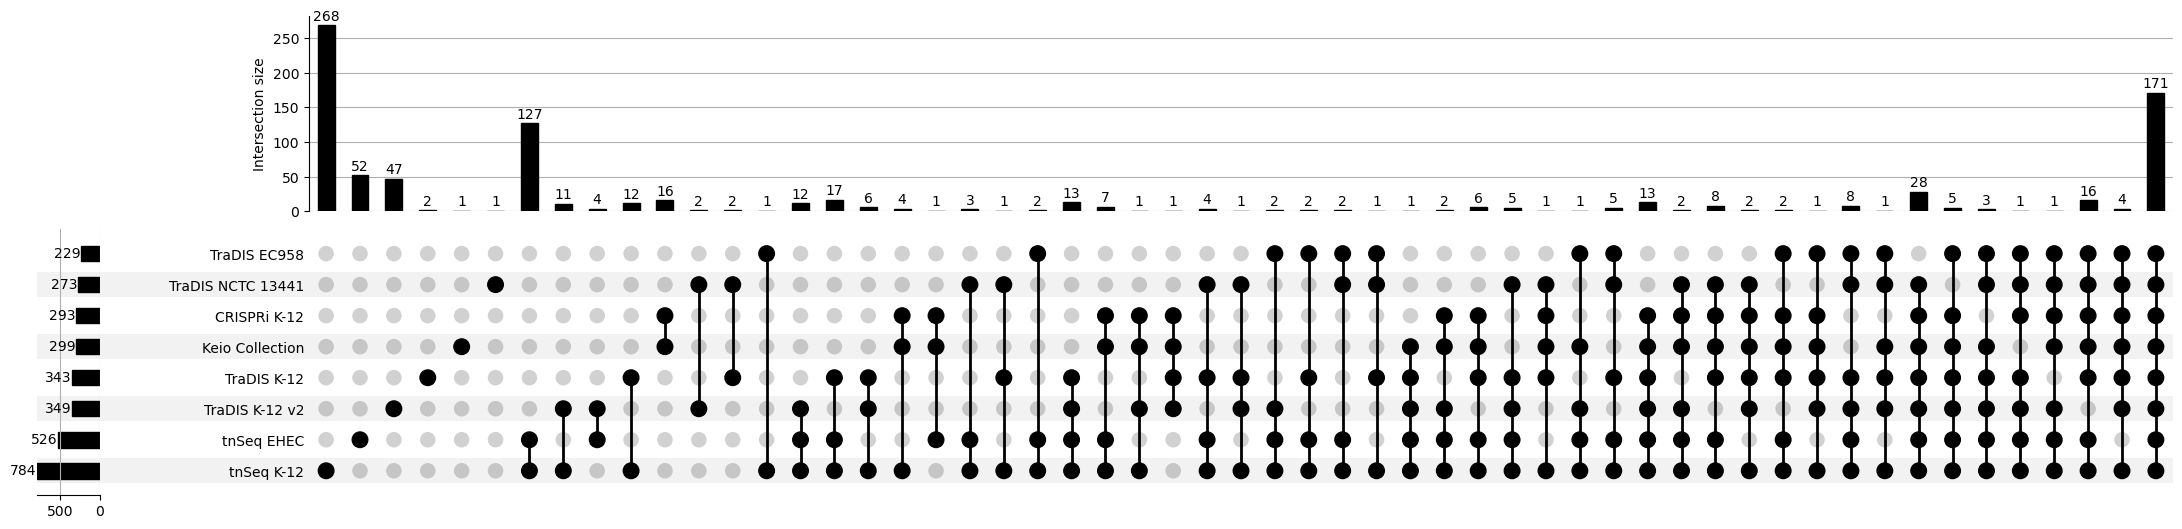

In [20]:
from upsetplot import from_memberships, UpSet
import matplotlib.pyplot as plt

# Union of all essential genes
all_genes = set.union(*essential_sets)

# Build membership lists
memberships = []
for gene in all_genes:
    gene_sets = [categories[i] for i, s in enumerate(essential_sets) if gene in s]
    memberships.append(gene_sets)

# Create data for plotting
data = from_memberships(memberships)

# Plot the UpSet
up = UpSet(
    data,
    orientation='horizontal',
    show_counts=True,
    subset_size='count'
)

fig = plt.figure(figsize=(12, 6))
up.plot(fig=fig)

plt.tight_layout()
plt.savefig('UpSet_E_Coli_Essential_Genes_Only.pdf')


/var/folders/_4/d5mt3z054svbl3nmjccm34yc0000gn/T/ipykernel_14080/2603179625.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


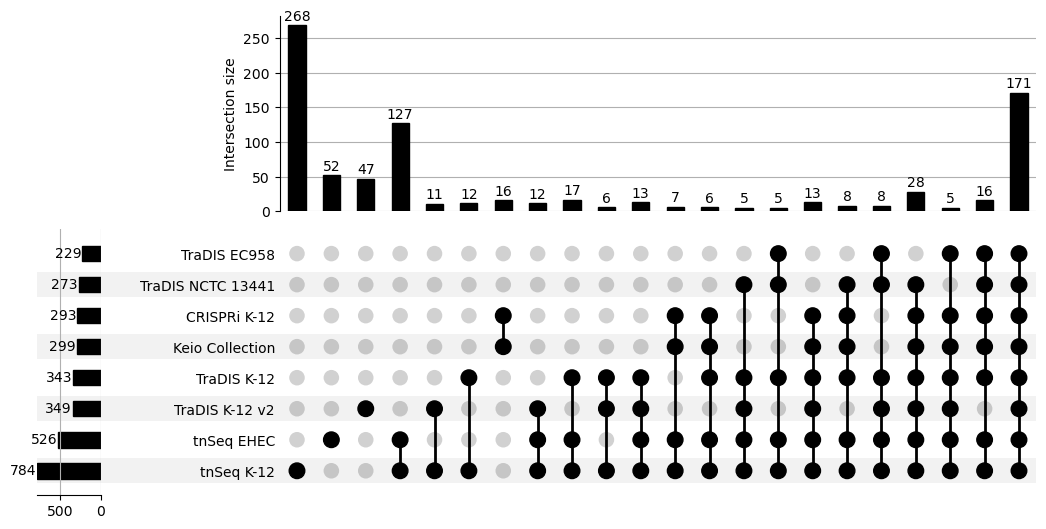

In [21]:
# Plot the UpSet
up = UpSet(
    data,
    orientation='horizontal',
    show_counts=True,
    subset_size='count',
    min_subset_size=5
)

fig = plt.figure(figsize=(12, 6))
up.plot(fig=fig)

plt.tight_layout()
plt.savefig('UpSet_E_Coli_Essential_Genes_Greater_than_5.pdf', bbox_inches='tight', dpi=300)

In [22]:
# Highlight all K-12 intersection
k12_sets = {'CRISPRi K-12', 'TraDIS K-12', 'tnSeq K-12', 'Keio Collection', 'TraDIS K-12 v2'}

# Get the exact match key from the full dataset
k12_key = tuple(sorted(k12_sets))  # sorted ensures ordering matches how upsetplot stores keys

# Get the intersection bars axis (usually fig.axes[0] for horizontal)
bar_ax = fig.axes[0]

# Find position of the K-12 combo
membership_labels = list(data.index)
try:
    k12_index = membership_labels.index(k12_key)
    
    # Highlight the bar (change color, draw rectangle, etc.)
    bars = bar_ax.patches
    if k12_index < len(bars):
        bars[k12_index].set_color('red')       # or use set_edgecolor, linewidth, etc.
        bars[k12_index].set_linewidth(2)
        bars[k12_index].set_hatch('//')        # optional for hatching pattern
except ValueError:
    print("K-12 intersection not found in filtered data.")


K-12 intersection not found in filtered data.


In [23]:
to_compare_essential = []

for t in to_compare:
    # Isolate just the essential genes
    to_compare_essential.append(t[t[t.columns[1]] == 1].reset_index(drop=True))


In [24]:
selected_combinations = []
cats = range(0, len(categories))
for c in cats:
    if c != 0:
        selected_combinations.extend(itertools.combinations(cats, c))
selected_combinations.append(tuple(cats))

selected_combination_names = []
for c in cats:
    if c != 0:
        selected_combination_names.extend(itertools.combinations(categories, c))
selected_combination_names.append(tuple(categories))

In [25]:
def create_cat_amounts(selected_combination_names, selected_combinations, to_compare_essential):
    cat_amounts = []

    for c, n in zip(selected_combinations, selected_combination_names):
        #print(n)
        if len(c) == 2:
            # paired
            id1 = c[0]
            id2 = c[1]
            cat_amounts.append(len(pd.merge(to_compare_essential[id1], to_compare_essential[id2], on='b ID', how='inner')))        
        elif len(c) > 2 and len(c) <= 8:
            # lengths between 2 and 8 (all)
            merge = to_compare_essential[c[0]]
            j = 1
            while j < len(c):
                merge = pd.merge(merge, to_compare_essential[c[j]], on='b ID', how='inner')
                j += 1
            cat_amounts.append(len(merge))
        else:
            # singles
            idx = c[0]
            cat_amounts.append(len(to_compare_essential[idx]))
    return cat_amounts


In [26]:
cat_amounts = create_cat_amounts(selected_combination_names, selected_combinations, to_compare_essential)

In [27]:
# Make a dataframe of all possible combinations
comb_len = []
for i in selected_combinations:
    comb_len.append(len(i))

all_possibilities = pd.DataFrame(zip(selected_combination_names, comb_len, cat_amounts)).rename(columns={0:'Included Data', 1:'Number of Datasets Included', 2:'Essential Genes'})

#all_possibilities.to_excel('./E_Coli_Shared_Essential_Gene_Analysis.xlsx')

In [28]:
binary_data = []
for combo in selected_combination_names:
    row = {dataset: dataset in combo for dataset in categories}
    binary_data.append(row)

In [29]:
df = pd.DataFrame(binary_data)
df['Shared Essential Genes'] = cat_amounts
df.set_index(categories, inplace=True)

upset_series = df['Shared Essential Genes']

In [30]:
upset_series = upset_series.sort_values(ascending=False)

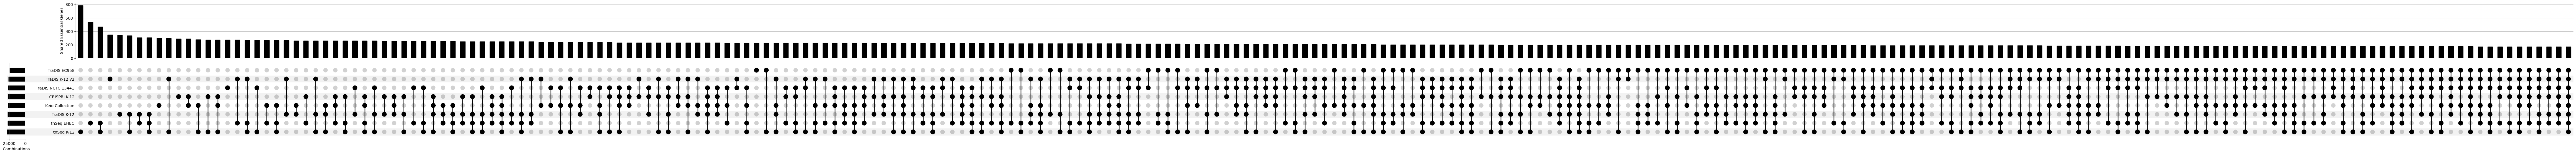

In [31]:
plot_genes = plot(upset_series, sort_by='input')

plot_genes['intersections'].set_ylabel('Shared Essential Genes')
plot_genes['totals'].set_xlabel('Combinations')

#pyplot.title("Shared Essential Genes in " + r"$\it{E.\ coli}$", size=20)
#pyplot.savefig('UpSetPlot_of_Shared_Essential_Genes_E_Coli_FULL_11032025_tnseq_adj.pdf', bbox_inches='tight', pad_inches=0.2)
pyplot.show()

In [32]:
# Plot just singles + pairs + all 8 together
selected_combinations = []
cats = range(0, len(categories))
selected_combinations.extend(itertools.combinations(cats, 1))
selected_combinations.extend(itertools.combinations(cats, 2))
selected_combinations.append(tuple(cats))

selected_combination_names = []
selected_combination_names.extend(itertools.combinations(categories, 1))
selected_combination_names.extend(itertools.combinations(categories, 2))
selected_combination_names.append(tuple(categories))

In [33]:
cat_amounts_2 = create_cat_amounts(selected_combination_names, selected_combinations, to_compare_essential)

In [34]:
binary_data = []
for combo in selected_combination_names:
    row = {dataset: dataset in combo for dataset in categories}
    binary_data.append(row)

In [35]:
df = pd.DataFrame(binary_data)
df['Shared Essential Genes'] = cat_amounts_2
df.set_index(categories, inplace=True)

upset_series = df['Shared Essential Genes']

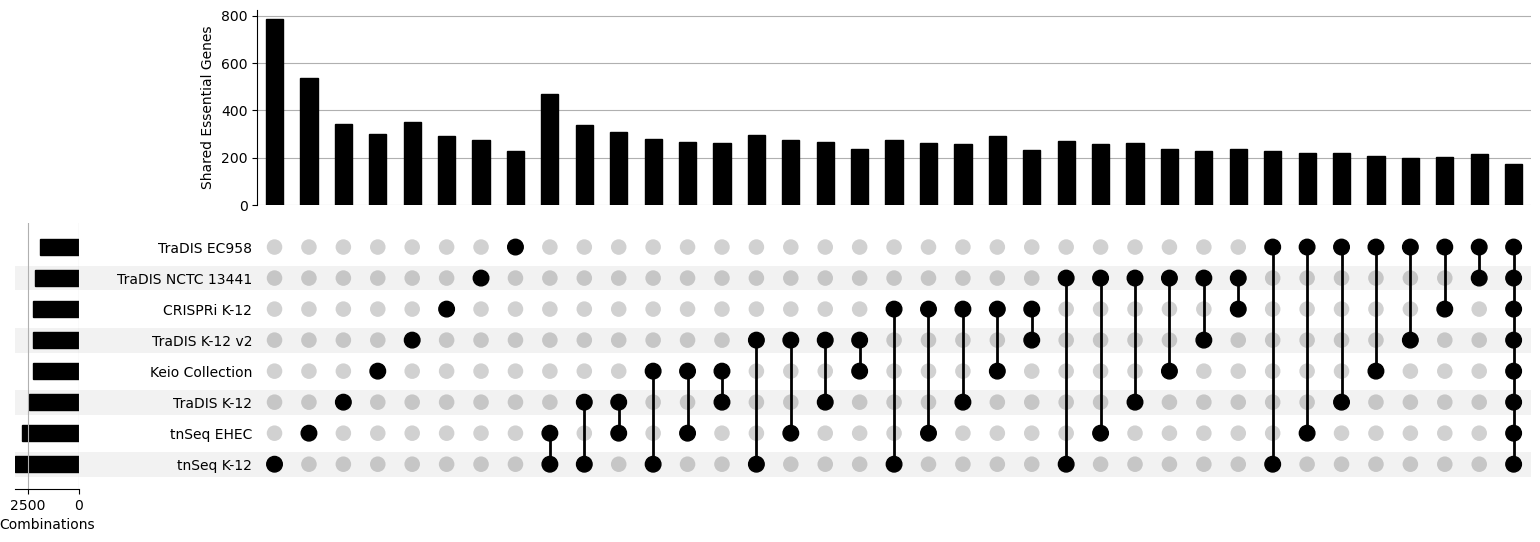

In [36]:
plot_genes = plot(upset_series)

plot_genes['intersections'].set_ylabel('Shared Essential Genes')
plot_genes['totals'].set_xlabel('Combinations')

#pyplot.title("Shared Essential Genes in " + r"$\it{E.\ coli}$", size=20)
#pyplot.savefig('UpSetPlot_of_Shared_Essential_Genes_E_Coli_11032025_tnseq_adj.pdf', bbox_inches='tight', pad_inches=0.2)
pyplot.show()

In [37]:
to_compare

[       b ID CRISPRi K12 Gene Essentiality
 0     b3241                             0
 1     b3240                             0
 2     b3243                             0
 3     b3242                             0
 4     b2836                             0
 ...     ...                           ...
 3917  b4004                             0
 3918  b4003                             0
 3919  b3040                             0
 3920  b4046                             0
 3921  b1852                             0
 
 [3922 rows x 2 columns],
        b ID  TraDIS K12 Gene Essentiality
 0     b4634                           0.0
 1     b4693                           0.0
 2     b3241                           0.0
 3     b3240                           0.0
 4     b3243                           0.0
 ...     ...                           ...
 4485  b4004                           0.0
 4486  b4003                           0.0
 4487  b3040                           0.0
 4488  b4046              

In [38]:
# Create cumulative count of essential genes
merge = to_compare_essential[0]
j = 1
while j < len(to_compare_essential):
    merge = pd.merge(merge, to_compare_essential[j], on='b ID', how='outer')
    j+=1

merge.fillna(0, inplace=True) # fill NaNs with 0s

# convert all columns to integers
i = 0
for c in merge.columns:
    if i > 1:
        merge[c] = merge[c].astype(int)
    i += 1

#merge.to_excel('./Essential_Genes_Cumulative.xlsx') # Read out to excel file


In [39]:
for c in merge.columns:
    if 'b ID' not in c:
        total_ess = len(merge)
        found_ess = merge[c].sum()
        print(c, 'is present as', (found_ess/total_ess)*100, 'of', found_ess)

CRISPRi K12 Gene Essentiality is present as 31.641468682505398 of 293
TraDIS K12 Gene Essentiality is present as 37.04103671706264 of 343
tnSeq EHEC Gene Essentiality is present as 57.99136069114471 of 537
tnSeq K12 Gene Essentiality is present as 84.98920086393088 of 787
Keio Gene Essentiality is present as 32.289416846652266 of 299
TraDIS EC958 Gene Essentiality is present as 24.73002159827214 of 229
TraDIS NCTC13441 Gene Essentiality is present as 29.481641468682508 of 273
TraDIS BW25113 Gene Essentiality is present as 37.6889848812095 of 349


In [41]:
# add uniprot IDs
uid_decode = pd.read_csv('./uniprot_ID_Gene_Names.tsv', sep='\t')


In [42]:
temp = uid_decode['Gene Names'].str.split(' ', expand = True)

def extract_b_id(row):
    b_matches = row[row.str.match(r'^b\d+$', na=False)]
    return b_matches.iloc[0] if not b_matches.empty else "none_found"

# Step 3: Apply to each row
b_ids = temp.apply(extract_b_id, axis=1)

In [43]:
uid_decode['b ID'] = b_ids


In [44]:
b_to_uids = uid_decode[uid_decode['b ID'] != 'none_found'].drop(columns='Gene Names').reset_index(drop=True)

In [45]:
b_to_uids = b_to_uids.rename(columns={'Entry':'Uniprot_ID'})

In [46]:
temp_2 = pd.merge(merge, b_to_uids, on='b ID', how='left', indicator=True)

In [47]:
temp_2[temp_2['_merge'] != 'both'].to_csv('Missing_Uniprot_IDs.csv')

In [48]:
temp_2[temp_2['_merge'] == 'both'].drop(columns=['_merge']).to_csv('E_Coli_Essential_Genes_with_Uniprot_IDs.csv')

In [49]:
temp_2 = temp_2.drop(columns='_merge')

In [50]:
# Now we want the gene names
bid_name = pd.read_csv('./Gene_Names_and_b_IDs.txt', sep='\t')

In [51]:
bid_name = bid_name.rename(columns={'Accession-1':'b ID'})

In [52]:
temp_2 = temp_2.drop_duplicates()

In [53]:
ann = pd.merge(temp_2, bid_name, on='b ID', indicator=True)

In [54]:
ann = ann.drop(columns=['_merge'])

In [55]:
ann.to_csv('E_Coli_Essential_Genes_with_Uniprot_IDs_and_Gene_Names.csv')